In [1]:
import os
import pandas as pd
import rioxarray as rxr
import xarray as xr
from dataclasses import asdict
from dscreator.cfarray.attributes import DatasetAttrsGrid, VariableAttrs
from datetime import datetime
from dscreator import utils
from dscreator.storage import BaseHandler, get_storage_handler
from dscreator.sources.base import BaseExtractor, NamedArray, NamedTrajectory, Point, FeatureBase
from dscreator.sources.ferrybox.extractor import TrajectoryExtractor
from sqlalchemy import create_engine
from dscreator.config import SETTINGS
from dscreator.datasets.trajectories.ferrybox import FerryboxTrajBuilder
import numpy as np

In [2]:
boat = "FA"
measurement_parameters = ["Temperature", "Salinity", "Oxygen"]
uuid="29b7de62-e1fa-4dce-90e4-7ff8a0931397"
datasetname="ColorFantasy_ferrybox"
stationname="ColorFantasy"
projectname="NorSoop"

In [3]:
engine = create_engine(SETTINGS.database_url)
te = TrajectoryExtractor(engine, boat, measurement_parameters)

years = [2017, 2018, 2019, 2020, 2021, 2022]
# 2022 Feb has 29 days
months = [i+1 for i in range(12)]
days = [31, 28, 31, 30, 31, 30, 31,31,30,31,30,31]
ts_array = []
for y in years:
    for m,d in zip(months, days):
        print(f" about to fetch month {m} end date {d}")
        if y==2020 and m ==2:
            d = 29
        print(f" about to fetch month {m} end date {d}")
        ts_array.append(
            te.fetch_slice(start_time=datetime(y, m, 1, 0, 0, 0), end_time=datetime(y, m, d, 0, 0, 0)))
ts = ts_array[0]
for i in range(1, len(ts_array)):
     ts = ts + ts_array[i]
# ts=te.fetch_slice(start_time=datetime(2022, 12, 29, 0, 0, 0), end_time=datetime(2020, 1, 2, 0, 0, 0))


 about to fetch month 1 end date 31
 about to fetch month 1 end date 31
 about to fetch month 2 end date 28
 about to fetch month 2 end date 28
 about to fetch month 3 end date 31
 about to fetch month 3 end date 31
 about to fetch month 4 end date 30
 about to fetch month 4 end date 30
 about to fetch month 5 end date 31
 about to fetch month 5 end date 31
 about to fetch month 6 end date 30
 about to fetch month 6 end date 30
 about to fetch month 7 end date 31
 about to fetch month 7 end date 31
 about to fetch month 8 end date 31
 about to fetch month 8 end date 31
 about to fetch month 9 end date 30
 about to fetch month 9 end date 30
 about to fetch month 10 end date 31
 about to fetch month 10 end date 31
 about to fetch month 11 end date 30
 about to fetch month 11 end date 30
 about to fetch month 12 end date 31
 about to fetch month 12 end date 31
 about to fetch month 1 end date 31
 about to fetch month 1 end date 31
 about to fetch month 2 end date 28
 about to fetch month 

In [4]:
print(f"Creating manual QC lookup list")
rm_T = []
rm_ox = []
for file in os.listdir(os.getcwd()+'/Norsoop-manual-qc-files'):
    if file.startswith(boat) and 'ox_sat' not in file:
        rm_T.append(pd.read_csv('Norsoop-manual-qc-files/'+file, header=None))
    if file.startswith(boat) and 'ox_sat' in file:
        rm_ox.append(pd.read_csv('Norsoop-manual-qc-files/'+file, header=None))
bad_T = pd.concat(rm_T, ignore_index=True)
bad_ox = pd.concat(rm_ox, ignore_index=True)
bad_T = np.array([dt.to_pydatetime() for dt in pd.to_datetime(bad_T[bad_T.columns[0]]).to_list()])
bad_ox = np.array([dt.to_pydatetime() for dt in pd.to_datetime(bad_ox[bad_ox.columns[0]]).to_list()])
i_bad_T = np.intersect1d(np.array(ts.datetime_list), bad_T, return_indices=True)[1]
i_bad_ox = np.intersect1d(np.array(ts.datetime_list), bad_ox, return_indices=True)[1]
print(f"Found {len(i_bad_T)} timestamp with no flow, and {len(i_bad_ox)} with bad oxygen")
print(f"{len(np.intersect1d(i_bad_T, i_bad_ox))} timestamps overlap")
print(f"About to set values for oxygen to None for bad oxygen timestamps")



ts = NamedTrajectory(
    array_list=[NamedArray(variable_name=nta.variable_name, values=[val if i not in i_bad_ox else None for (i,val) in enumerate(nta.values)])
                if nta.variable_name=="Oxygen" else nta for nta in ts.array_list],
    datetime_list=ts.datetime_list,
    locations=ts.locations)

print(f"About to remove bad flow data. Before removal size of data based on location is "
      f"{len(ts.locations)}")
ts = NamedTrajectory(
    array_list=[NamedArray(nta.variable_name, list(np.delete(nta.values, i_bad_T)))
                for nta in ts.array_list],
    datetime_list=list(np.delete(ts.datetime_list, i_bad_T)),
    locations=list(np.delete(ts.locations, i_bad_T)))
print(f"After removal size of data based on location is {len(ts.locations)}")


Creating manual QC lookup list
Found 100880 timestamp with no flow, and 33445 with bad oxygen
19325 timestamps overlap
About to set values for oxygen to None for bad oxygen timestamps
About to remove bad flow data. Before removal size of data based on location is 1732546
After removal size of data based on location is 1631666


In [5]:
tb = FerryboxTrajBuilder(
    uuid=uuid,
    dataset_name=datasetname,
    station_name=stationname,
    project_name=projectname,
    is_acdd=True,
)
ds = tb.create(ts)

In [6]:
if ds.dims["time"] > 0:
    print(f"Saving dataset slice {ds.time[0].values} --> {ds.time[-1].values}")

    sh= get_storage_handler(
        project_name=str(datasetname),
        dataset_name=str(stationname),
        unlimited_dims=["time"],
        filename_prefix= f"FA-2017-2022"
    )
    sh.save_dataset(ds)
    print("Dataset was successfully saved")
else:
    print("Found no data for interval")

Saving dataset slice 2017-01-01T13:25:03.000000000 --> 2022-12-31T00:00:00.000000000
Dataset was successfully saved


KeysView(Frozen({'sea_water_temperature': <xarray.Variable (time: 1631666)>
[1631666 values with dtype=float64]
Attributes:
    long_name:      sea_water_temperature
    units:          degree_Celsius
    standard_name:  sea_water_temperature, 'salinity': <xarray.Variable (time: 1631666)>
[1631666 values with dtype=float64]
Attributes:
    long_name:      Sea Water Salinity
    units:          PSU
    standard_name:  sea_water_salinity, 'oxygen': <xarray.Variable (time: 1631666)>
[1631666 values with dtype=float64]
Attributes:
    long_name:      Sea Water Oxygen Saturation
    units:          %
    standard_name:  sea_water_oxygen_saturation, 'trajectory_name': <xarray.Variable ()>
[1 values with dtype=object]
Attributes:
    cf_role:  trajectory_id, 'time': <xarray.IndexVariable 'time' (time: 1631666)>
array(['2017-01-01T13:25:03.000000000', '2017-01-01T13:26:03.000000000',
       '2017-01-01T13:27:03.000000000', ..., '2022-12-30T23:58:00.000000000',
       '2022-12-30T23:59:00.00000

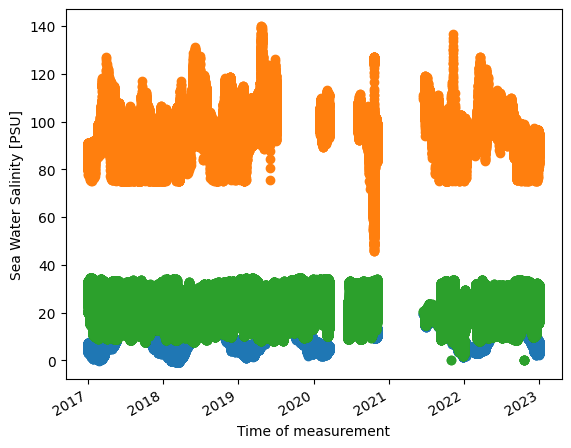

In [10]:
import netCDF4
import xarray as xr
#ds = netCDF4.Dataset("catalog/datasets/colorfantasy_ferrybox/ColorFantasy/FA-2017_acdd_colorfantasy.nc")
ds=xr.open_dataset("catalog/datasets/colorfantasy_ferrybox/ColorFantasy/FA-2017-2022_colorfantasy.nc")
print(ds.variables.keys())
sea_water_temperature = ds.variables['sea_water_temperature']  # access a variable in the file
ds.sea_water_temperature.plot.line("o")
oxygen = ds.variables['oxygen']  # access a variable in the file
ds.oxygen.plot.line("o")
salinity = ds.variables['salinity']  # access a variable in the file
ds.salinity.plot.line("o")
